#### Setup

Add the path from ASTAP (by default, ``C:\Program Files\astap\``) to your ``path`` environment variable, and then restart VS Code. If everything is good, the following code block should run and display the ASTAP CLI help

In [2]:
import subprocess
sub = subprocess.run(["astap_cli.exe", "-h"], shell=True, capture_output=True)
print(sub.stdout.decode())

ASTAP astrometric solver version CLI-2023.06.24
(C) 2018, 2022 by Han Kleijn. License MPL 2.0, Webpage: www.hnsky.org
Usage:
-f  filename  {fits, tiff, png, jpg files}
-r  radius_area_to_search[degrees]
-z  downsample_factor[0,1,2,3,4] {Downsample prior to solving. 0 is auto}
-fov diameter_field[degrees] {enter zero for auto}
-ra  center_right_ascension[hours]
-spd center_south_pole_distance[degrees]
-s  max_number_of_stars  {default 500}
-t  tolerance  {default 0.007}
-m  minimum_star_size["]  {default 1.5}
-check apply[y/n] {Apply check pattern filter prior to solving. Use for raw OSC images only when binning is 1x1}
-speed mode[auto/slow] {Slow is forcing reading a larger area from the star database (more overlap) to improve detection}
-o  file {Name the output files with this base path & file name}
-d  path {specify a path to the star database}
-analyse snr_min {Analyse only and report median HFD and number of stars used}
-extract snr_min {As -analyse but additionally write a .csv 

## Batch images footprint calculation

In [1]:
import os
import subprocess
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.time import Time, TimeDelta
import warnings
warnings.simplefilter('ignore', category=FITSFixedWarning)

In [2]:
# Specify image directory and filename template
main_folder = "P:\\Aurélien\\Astronomie\\Astrophoto\\01-Ciel profond\\IC5146-(Cocoon nebula)_2025-09-17_RC6_ASI1600MM_LRGB\\RAW"
# main_folder = "P:\\Aurélien\\Astronomie\\Astrophoto\\04-Exoplanetes\\HAT-P-18b_2025-05-16_RC6_ASI1600MM_R_180s"
# main_folder = "P:\\Aurélien\\Astronomie\\Astrophoto\\05-Asteroides\\3I-ATLAS_2025-07-24_RC6_ASI1600MM_L_300s"
# main_folder = "C:/Users/aurel/Desktop/Astro/2-Pilotage/N.I.N.A Images/Astro"
# main_folder = "C:/Users/aurel/Desktop/Astro/5-Capture/AstroPi/M 31"
# filename_template = "*LIGHT*ASI1600MM*.fits"
filename_template = "*Light*.fits"

In [3]:
# Find all images
files = glob.glob(f"{main_folder}\\**\\{filename_template}", recursive=True)
print(len(files), "images found")

188 images found


### Single image

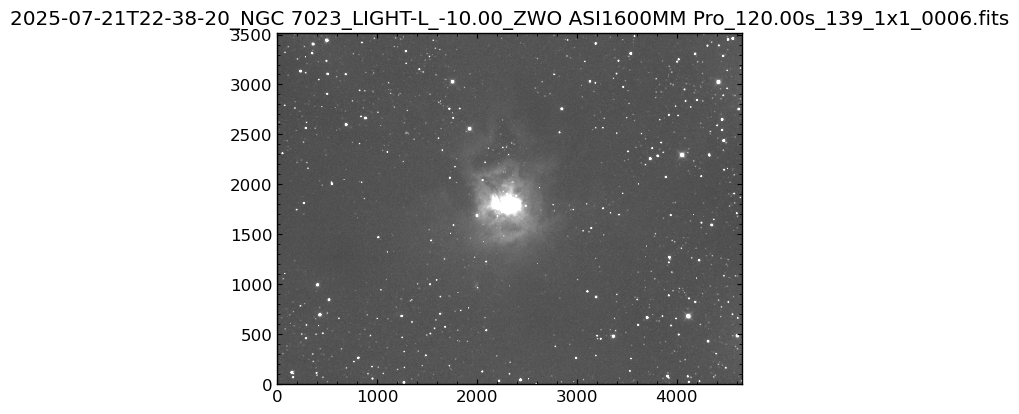

In [14]:
# Shows one random image
file = files[np.random.randint(len(files))]
with fits.open(file) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    
fig, ax = plt.subplots()
norm = ImageNormalize(data, interval=ZScaleInterval())
ax.imshow(data, norm=norm, origin='lower', cmap='gray')
ax.set_title(os.path.basename(file))
plt.show()

In [15]:
# Run platesolving of the image
astap_run = subprocess.run(["astap", "-f", file, "-r", "1"])
astap_run.check_returncode()

In [16]:
# Calculate WCS of the image
with open(file.replace(".fits", ".wcs"), 'r') as wcs_file:
    wcs_header = fits.Header.fromstring(wcs_file.read(), sep='\n')
    wcs = WCS(wcs_header)
# Clean up temporary files
os.remove(file.replace('.fits', '.ini'))
os.remove(file.replace('.fits', '.wcs'))

In [17]:
# Calculate footprint of the image
footprint = wcs.calc_footprint(header)

In [18]:
# Expand the footprint for visualization
header_scale = header.copy()
wcs_scale = wcs.copy()
scale = 5
header_scale['NAXIS1'] = header_scale['NAXIS1'] * scale
header_scale['NAXIS2'] = header_scale['NAXIS2'] * scale
wcs_scale.wcs.crpix[0] = wcs_scale.wcs.crpix[0] * scale
wcs_scale.wcs.crpix[1] = wcs_scale.wcs.crpix[1] * scale
footprint = wcs_scale.calc_footprint(header_scale)

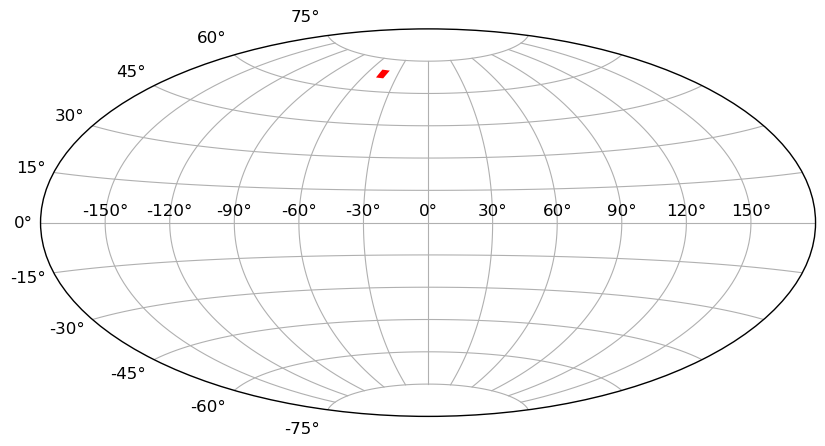

In [19]:
# Plot the footprint of the image
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': 'aitoff'})
ax.grid(True)
fp = np.deg2rad(footprint)
fp[fp>np.pi] -= 2*np.pi
q = Polygon(fp, closed=True, edgecolor='none', facecolor='r', alpha=1)
ax.add_patch(q)
plt.show()

## Batch processing

In [6]:
# deltatime = TimeDelta(9*86400-0.5*3600, format='sec')
for i, file in enumerate(tqdm(files)):
    # Open the image file
    with fits.open(file) as hdul:
        header = hdul[0].header
        data = hdul[0].data
    header['OBJECT'] = 'IC 5146'
    header['TELESCOP'] = 'RC6'
    header['OBSERVER'] = 'Aurelien Genin'
    # time = Time(header['DATE-OBS'], format='isot', scale='utc')
    # header['DATE-OBS'] = (time + deltatime).isot
    # header['COMMENT'] = 'DATE-OBS approximated by +9d-0.5h'
    # time_str = file.split('\\')[-1].split('_')[0]
    # date_str = time_str.split('T')[0]
    # hour_str = time_str.split('T')[1].split('.')[0].replace('-', ':')
    # time_str_new = (Time(f"{date_str}T{hour_str}", format='isot', scale='utc') + deltatime).isot.replace(':', '-')[:-4]
    # filename = file.replace(time_str, time_str_new).replace('M_31', 'M 31')
    filename = file
    # Update the header with the new object name
    hdul = fits.HDUList([fits.PrimaryHDU(data=data, header=header)])
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    hdul.writeto(filename, overwrite=True)

100%|██████████| 188/188 [09:31<00:00,  3.04s/it]


In [4]:
# database_file = "data/astro_footprint_database.csv"
database_file = "data/database.csv"

In [5]:
saved_list = []
# np.random.shuffle(files)  # Shuffle the files for random processing
for i, file in enumerate(tqdm(files)):
    # Open the image file
    with fits.open(file) as hdul:
        header = hdul[0].header
    # Run platesolving of the image
    astap_run = subprocess.run(["astap", "-f", file, "-r", "1"])
    try:
        astap_run.check_returncode()
    except subprocess.CalledProcessError as e:
        print(f"Error processing {file}: {e}")
        os.remove(file.replace('.fits', '.ini'))
        continue
    # Calculate WCS of the image
    with open(file.replace(".fits", ".wcs"), 'r') as wcs_file:
        wcs_header = fits.Header.fromstring(wcs_file.read(), sep='\n')
        wcs = WCS(wcs_header)
    # Clean up temporary files
    os.remove(file.replace('.fits', '.ini'))
    os.remove(file.replace('.fits', '.wcs'))
    # Calculate footprint of the image
    footprint = wcs.calc_footprint(header)
    # Save the WCS, footprint and header information
    saved = {'FILE': file.split('\\')[-1],
            'DATE': header['DATE-OBS'],
            'TARGET': header['OBJECT'],
            'FILTER': header['FILTER'],
            'EXPTIME': header['EXPTIME'],
            'RA': wcs.wcs.crval[0],
            'DEC': wcs.wcs.crval[1],
            'FP1_RA': footprint[0][0],
            'FP1_DEC': footprint[0][1],
            'FP2_RA': footprint[1][0],
            'FP2_DEC': footprint[1][1],
            'FP3_RA': footprint[2][0],
            'FP3_DEC': footprint[2][1],
            'FP4_RA': footprint[3][0],
            'FP4_DEC': footprint[3][1],
            'CTYPE1': wcs.wcs.ctype[0],
            'CTYPE2': wcs.wcs.ctype[1],
            'CRVAL1': wcs.wcs.crval[0],
            'CRVAL2': wcs.wcs.crval[1],
            'CRPIX1': wcs.wcs.crpix[0],
            'CRPIX2': wcs.wcs.crpix[1],
            'CD1_1': wcs.wcs.cd[0][0],
            'CD1_2': wcs.wcs.cd[0][1],
            'CD2_1': wcs.wcs.cd[1][0],
            'CD2_2': wcs.wcs.cd[1][1],
            'NAXIS1': header['NAXIS1'],
            'NAXIS2': header['NAXIS2'],}
    saved_list.append(saved)
    # Save the information to a CSV file
    if i%1==0:
        df = pd.DataFrame(saved_list)
        df.to_csv(database_file, index=False, mode='a', header=not os.path.exists(database_file))
        saved_list = []  # Reset the list after saving to CSV
df = pd.DataFrame(saved_list)
df.to_csv(database_file, index=False, mode='a', header=not os.path.exists(database_file))

100%|██████████| 188/188 [06:29<00:00,  2.07s/it]


In [ ]:
# Sort the database by date
df = pd.read_csv("data/astro_footprint_database.csv")
df.sort_values(by=['DATE'], ascending=True, inplace=True)
df.to_csv("data/astro_footprint_database.csv", index=False)  # Save the final DataFrame to CSV